In [2]:
import os
import shutil
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from rinet.data_sim import random_mixture_sample

# for reproducibility
SEED = 42
np.random.seed(SEED)


In [3]:
# generate dataset

data_path = '../simulated_2d/'

n_dimensions = 2  # number of dimensions
n_components = [1, 2]  # possible number of pathological components
sample_sizes = [200, 300, 500, 1000, 5000, 10000]  # possible no. samples

n_samples = 15000

data = []  # list of vectors containing mixture samples
sizes = []
components = []
mean_vecs = []
std_devs = []
corr_mats = []
for i in range(n_samples):

    if i % 500 == 0:
        print(i)

    sample, mean_vectors, stds, corr_matrices, comps, sz = random_mixture_sample(
        n_dimensions=n_dimensions, 
        n_components=np.random.choice(n_components),
        n_samples=np.random.choice(sample_sizes),
        quantize_step=np.random.choice([0, 0.05, 0.1, 0.2]),
    )

    data.append(sample)
    mean_vecs.append(mean_vectors)
    std_devs.append(stds)
    corr_mats.append(corr_matrices)
    components.append(comps)
    sizes.append(sz)



0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500


In [4]:
# standardize samples, so model can be scale independent
data_scaled = []
targets = []
for c, i in enumerate(data):

    if c % 500 == 0:
        print(c)

    # record scaled data points
    data_scaled.append((i-i.mean(axis=0))/i.std(axis=0))

    # transform target statistics
    a = 1 / i.std(axis=0)  # reciprocal of sample std for scaling
    b = -i.mean(axis=0)  # negative of sample mean for shifting
    transformed_mean = a * (mean_vecs[c][0] + b)  # transform mean
    transformed_std = a*std_devs[c][0]

    # create NN target from standardized sample
    targets.append(np.hstack([
        transformed_mean,
        transformed_std,
        corr_mats[c][0][0, 1],
        sizes[c][0]/sum(sizes[c])
    ]))


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500


In [5]:
# split
idx_train, idx_test = train_test_split(range(len(data)), test_size=(2000/len(data)), random_state=10)
assert len(set(idx_train).intersection(idx_test))==0, 'Error: train/test overlap'
idx_val, idx_test = train_test_split(idx_test, test_size=0.5, random_state=10)
assert len(set(idx_val).intersection(idx_test))==0, 'Error: val/test overlap'

print(len(idx_train))
print(len(idx_val))
print(len(idx_test))


13000
1000
1000


In [6]:
# save generated data
if not os.path.exists(data_path):
    os.makedirs(data_path)
    os.makedirs(data_path+'/train/')
    os.makedirs(data_path+'/val/')
    os.makedirs(data_path+'/test/')
else:
    shutil.rmtree(data_path)
    os.makedirs(data_path)
    os.makedirs(data_path+'/train/')
    os.makedirs(data_path+'/val/')
    os.makedirs(data_path+'/test/')

for idx, split in zip([idx_train, idx_val, idx_test], ['train', 'val', 'test']):
    with open(data_path+'/' + split + '/input_data.pkl', 'wb') as handle:
        pickle.dump([data_scaled[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/original_data.pkl', 'wb') as handle:
        pickle.dump([data[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/target_data.pkl', 'wb') as handle:
        pickle.dump([targets[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/means.pkl', 'wb') as handle:
        pickle.dump([mean_vecs[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/stds.pkl', 'wb') as handle:
        pickle.dump([std_devs[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/sizes.pkl', 'wb') as handle:
        pickle.dump([sizes[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/components.pkl', 'wb') as handle:
        pickle.dump([components[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/corr_mats.pkl', 'wb') as handle:
        pickle.dump([corr_mats[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)


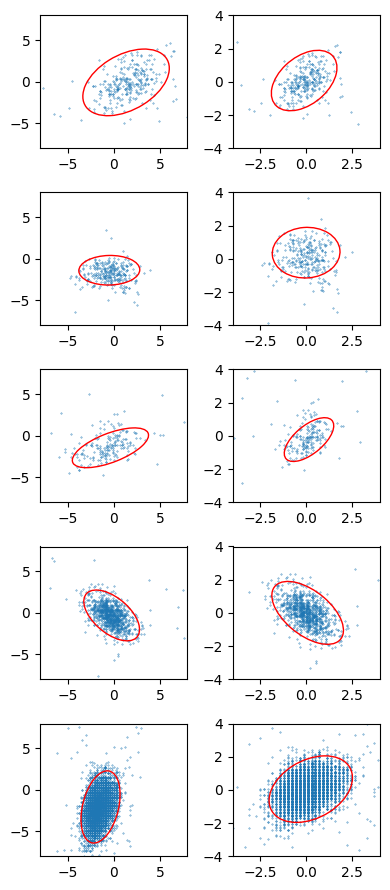

In [7]:
# checking transformation:

# does a sample using standardized target parameters match the reference Gaussian?

import matplotlib.pyplot as plt
from rinet.data_sim import plot_cov_ellipse, correlation_to_covariance

plt.figure(figsize=(4, 9))
for i in range(5):

    idx = np.random.choice(len(data))  # select random sample index

    cov_mat = correlation_to_covariance(corr_mats[idx][0], std_devs[idx][0])

    # plot unscaled data with 95% ellipse
    plt.subplot(5, 2, (i*2)+1)
    plt.scatter(data[idx][:, 0], data[idx][:, 1], s=0.1)
    ellipse = plot_cov_ellipse(mean_vecs[idx][0], cov_mat, fc='none', color='r')
    plt.gca().add_patch(ellipse)
    plt.xlim([-8, 8])
    plt.ylim([-8, 8])

    cov_mat = correlation_to_covariance(corr_mats[idx][0], targets[idx][2:4])

    # plot scaled sample with 95% ellipse
    plt.subplot(5, 2, (i*2)+2)
    plt.scatter(data_scaled[idx][:, 0], data_scaled[idx][:, 1], s=0.1)
    ellipse = plot_cov_ellipse(targets[idx][:2], cov_mat, fc='none', color='r')
    plt.gca().add_patch(ellipse)
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plt.gcf().tight_layout()


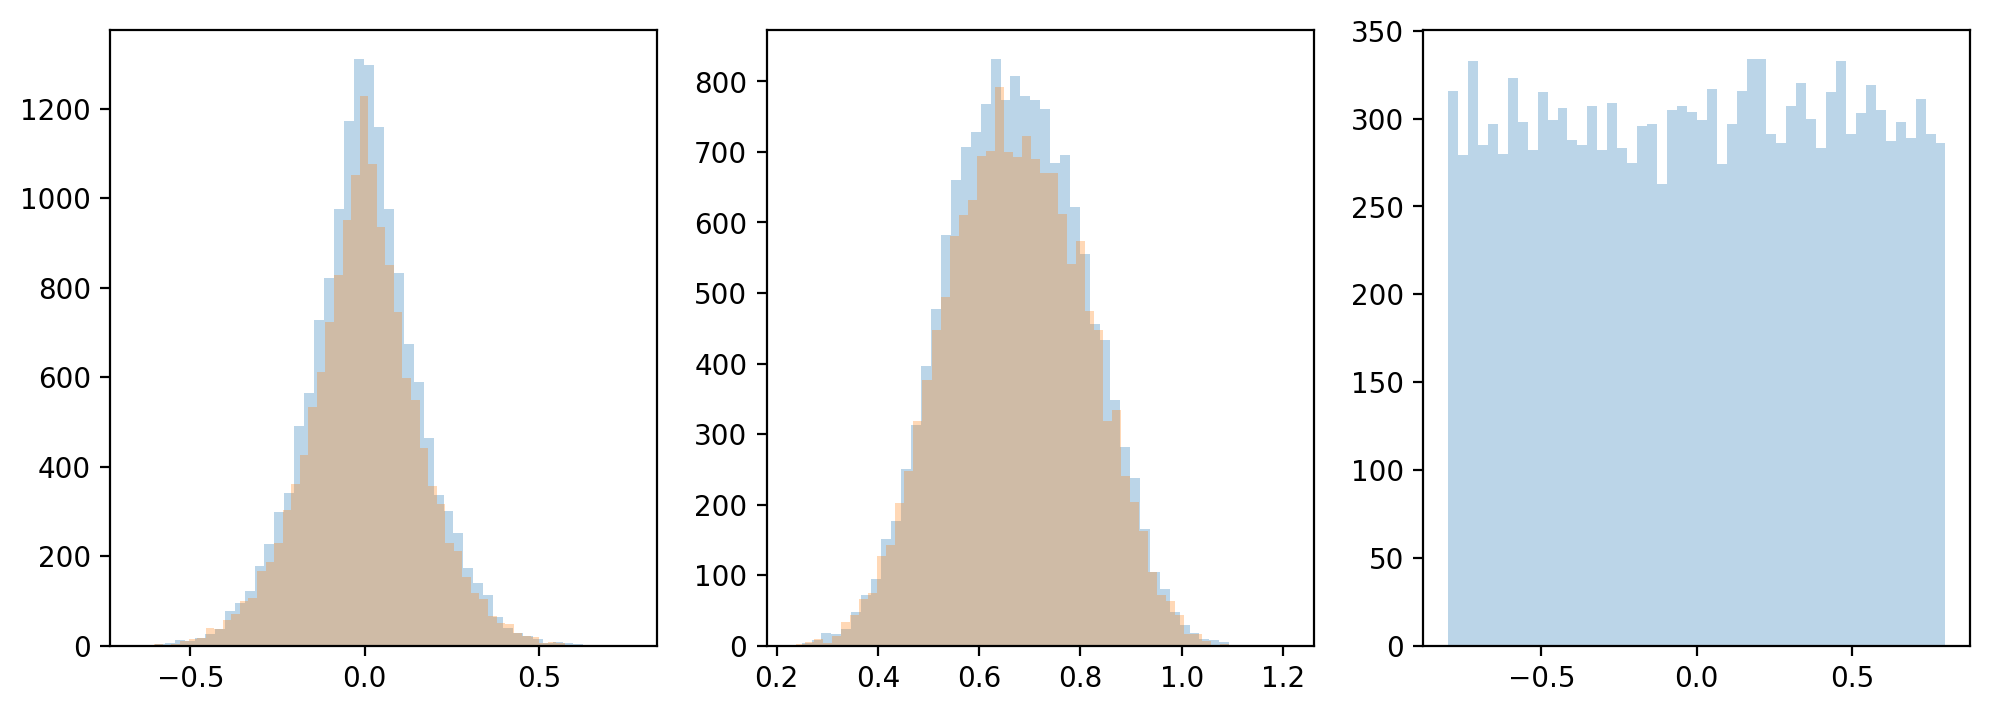

In [8]:
plt.figure(figsize=(12, 4), dpi=200)
plt.subplot(1, 3, 1)
plt.hist([i[0] for i in targets], 50, alpha=0.3);
plt.hist([i[1] for i in targets], 50, alpha=0.3);
plt.subplot(1, 3, 2)
plt.hist([i[2] for i in targets], 50, alpha=0.3);
plt.hist([i[3] for i in targets], 50, alpha=0.3);
plt.subplot(1, 3, 3)
plt.hist([i[4] for i in targets], 50, alpha=0.3);
